# Author: Sevendi Eldrige Rifki Poluan

In [1]:
!nvidia-smi

Tue May 23 03:40:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:65:00.0 Off |                  N/A |
|  0%   48C    P0   118W / 390W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install opencv-python

In [ ]:
!apt-get install libgl1-mesa-glx -y

# Import the required libraries

In [134]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Prepare the datasets

In [2]:
!ls chest_xray/train

NORMAL	PNEUMONIA


In [3]:
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory("chest_xray/train", label_mode="categorical", class_names=CLASS_NAMES, image_size=(224, 224), shuffle=True, seed=42, batch_size=None)
test_ds = tf.keras.preprocessing.image_dataset_from_directory("chest_xray/train", label_mode="categorical", class_names=CLASS_NAMES, image_size=(224, 224), shuffle=True, seed=42, batch_size=None)
val_ds = tf.keras.preprocessing.image_dataset_from_directory("chest_xray/train", label_mode="categorical", class_names=CLASS_NAMES, image_size=(224, 224), shuffle=True, seed=42, batch_size=None)

Found 5216 files belonging to 2 classes.


2023-05-23 03:40:29.051773: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22244 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Found 5216 files belonging to 2 classes.
Found 5216 files belonging to 2 classes.


# Show some sample images

2023-05-22 17:07:34.798476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5216]
	 [[{{node Placeholder/_0}}]]
2023-05-22 17:07:34.798691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5216]
	 [[{{node Placeholder/_4}}]]


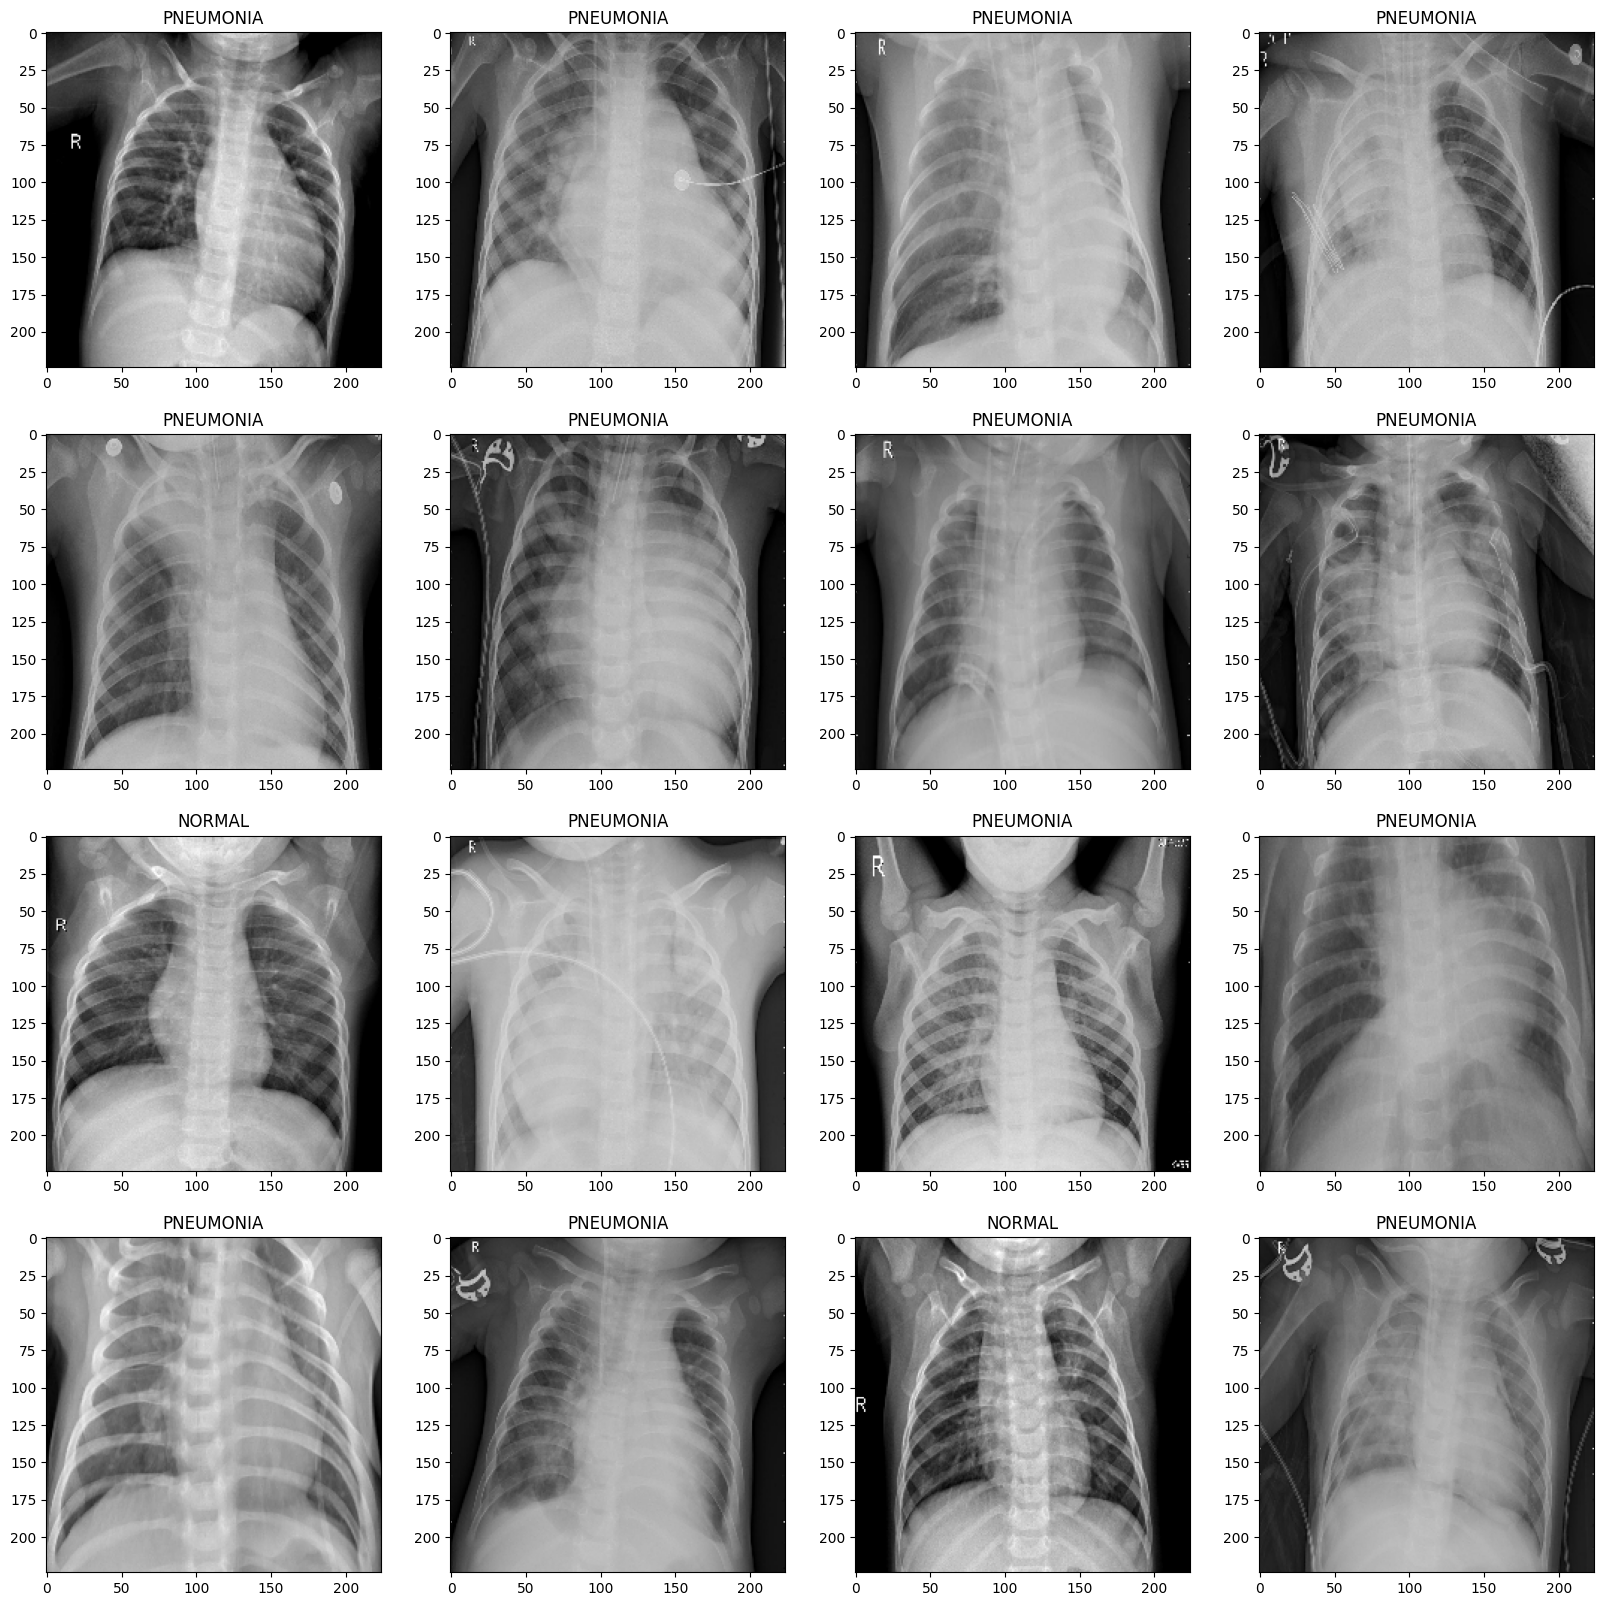

In [5]:
row, col = 4, 4
fig, axes = plt.subplots(row, col, figsize=(20, 20))

for index, x in enumerate(train_ds):
    axes[index // row, index % col].imshow(x[0].numpy().astype(int))
    axes[index // row, index % col].set_title(CLASS_NAMES[x[1].numpy().argmax()])
    
    if index == (row * col) - 1:
        break
        
plt.show()
    

# Prepare dataset for training

In [126]:
BATCH_SIZE = 32
IMG_SIZE = [256, 256]

def func(image, label):
    return tf.image.resize(image, IMG_SIZE), label

train = train_ds.map(func).batch(BATCH_SIZE).shuffle(1000).prefetch(tf.data.AUTOTUNE).cache()
test = test_ds.map(func).batch(BATCH_SIZE).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val = val_ds.map(func).batch(BATCH_SIZE).shuffle(1000).prefetch(tf.data.AUTOTUNE)

# Build the model

In [127]:
def create_model(): 
    efficient_net = tf.keras.applications.VGG19(include_top=False, weights="imagenet", input_shape=IMG_SIZE + [3])
    efficient_net.trainable = False 
    x = tf.keras.layers.GlobalAveragePooling2D()(efficient_net.output)
    outputs = tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax")(x)
    model = tf.keras.Model(efficient_net.input, outputs)
    
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    return model

In [128]:
model = create_model()

In [112]:
model.summary()

Model: "model_255"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0 

# Callbacks

In [113]:
class ModelCheckpointCustom(tf.keras.callbacks.Callback):
    
    def __init__(self, model_path, save_best_only=False):
        super(ModelCheckpointCustom, self).__init__()
         
        self.model_path = model_path
        self.save_best_only = save_best_only
        self.best_val_loss = float('inf') 

    def on_epoch_end(self, epoch, logs=None): 
        
        current_val_loss = 0 if logs['val_loss'] is None else logs['val_loss']
         
        if self.save_best_only and current_val_loss < self.best_val_loss: 
            self.best_val_loss = current_val_loss 
            self.model.save_weights(self.model_path) 
        else: 
            self.model.save_weights(self.model_path)  

save_callbacks = ModelCheckpointCustom(model_path='saved_weights/model.weights.h5', save_best_only=True)

In [114]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)

# Train the model

In [115]:
EPOCHS = 10
history = model.fit(train, epochs=EPOCHS, validation_data=val, validation_steps=len(val) * .2, 
                    callbacks=[early_stopping, save_callbacks])

Epoch 1/10
163/163 [==============================] - 17s 98ms/step - loss: 0.4554 - accuracy: 0.8485 - val_loss: 0.1532 - val_accuracy: 0.9432
Epoch 2/10
163/163 [==============================] - 15s 95ms/step - loss: 0.1360 - accuracy: 0.9484 - val_loss: 0.0942 - val_accuracy: 0.9631
Epoch 3/10
163/163 [==============================] - 16s 100ms/step - loss: 0.1030 - accuracy: 0.9613 - val_loss: 0.0918 - val_accuracy: 0.9688
Epoch 4/10
163/163 [==============================] - 15s 94ms/step - loss: 0.0863 - accuracy: 0.9666 - val_loss: 0.0805 - val_accuracy: 0.9688
Epoch 5/10
163/163 [==============================] - 15s 95ms/step - loss: 0.0757 - accuracy: 0.9712 - val_loss: 0.0786 - val_accuracy: 0.9716
Epoch 6/10
163/163 [==============================] - 16s 96ms/step - loss: 0.0679 - accuracy: 0.9734 - val_loss: 0.0679 - val_accuracy: 0.9744
Epoch 7/10
163/163 [==============================] - 16s 97ms/step - loss: 0.0619 - accuracy: 0.9764 - val_loss: 0.0456 - val_accuracy

# Performance evaluation

<Axes: >

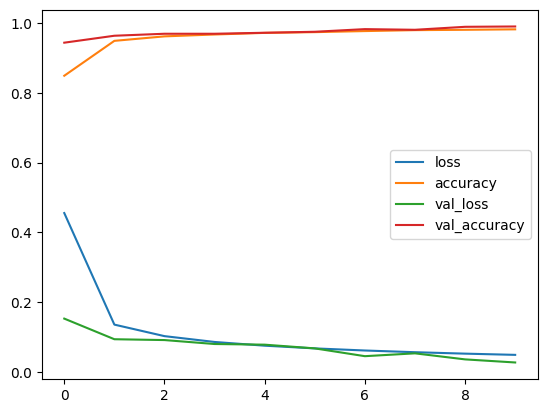

In [123]:
pd.DataFrame(history.history).plot()

# Test the model

In [116]:
loaded_model = create_model()

In [117]:
loaded_model.load_weights("saved_weights/model.weights.h5")

In [118]:
y_pred = loaded_model.evaluate(test)

2023-05-23 04:31:11.035377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5216]
	 [[{{node Placeholder/_4}}]]
2023-05-23 04:31:11.036366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5216]
	 [[{{node Placeholder/_4}}]]


163/163 [==============================] - 14s 53ms/step - loss: 0.0411 - accuracy: 0.9864


In [119]:
print("Testing accuracy:", y_pred[1])

Testing accuracy: 0.9863880276679993


# eXplainable AI

In [129]:
class GradCAM(object):
    
    def __init__(self, model, alpha=0.8, beta=0.3):
        
        self.model = model
        self.alpha = alpha
        self.beta = beta
 
    def apply_heatmap(self, heatmap, image): 
        # Resize the heatmap to match the size of the original image
        heatmap = cv2.resize(heatmap, image.shape[:-1]) 
        
        # Apply color map (JET) to the heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)   
        
        # Combine the original image and heatmap
        superimposed_img = cv2.addWeighted(np.array(image).astype(np.float32), self.alpha, np.array(heatmap).astype(np.float32), self.beta, 0)
        
        return np.array(superimposed_img).astype(np.uint8)
    
    def gradCAM(self, x_test=None, name='black_max_pool_2', index_class=0):
        
        with tf.GradientTape() as tape:
             # Get the specified layer from the model
            last_conv_layer = self.model.get_layer(name) 
            
            # Create a new model that outputs the predicted class and the output of the specified layer
            grad_model = tf.keras.Model([self.model.input], [self.model.output, last_conv_layer.output])
              
            # Get the model predictions and the output of the specified layer for the input image
            model_out, last_conv_layer = grad_model(np.expand_dims(x_test, axis=0))   
            
            # Extract the predicted class output
            class_out = model_out[:, index_class]  
               
            # Compute the gradients of the predicted class output with respect to the last convolutional layer
            grads = tape.gradient(class_out, last_conv_layer)   
            
            # Compute the average gradient values across the spatial dimensions (8x8) and the channels (1152)
            pooled_grads = tf.reduce_mean(grads, axis=(0, 3)) # (1, 8, 8, 1152) -> (8, 8)
            
            # Compute the average activation values across the spatial dimensions (8x8) and the channels (1152)
            last_conv_layer = tf.reduce_mean(last_conv_layer, axis=(0, 3))
        
        # Element-wise multiplication of the gradients and the activation values
        heatmap = tf.multiply(pooled_grads, last_conv_layer)  
        
        # Set negative values to zero
        heatmap = np.maximum(heatmap, 0)
        
        # Normalize the heatmap values between 0 and 1
        heatmap /= np.max(heatmap)    
        heatmap = np.array(heatmap) 
        
        # Apply the heatmap on the input image and return the result
        return self.apply_heatmap(heatmap, x_test)   
     

In [130]:
gradCam = GradCAM(loaded_model, alpha=0.8, beta=0.2)

2023-05-23 04:43:01.862883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5216]
	 [[{{node Placeholder/_4}}]]
2023-05-23 04:43:01.863121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5216]
	 [[{{node Placeholder/_4}}]]
/tmp/ipykernel_209274/660290693.py:52: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)


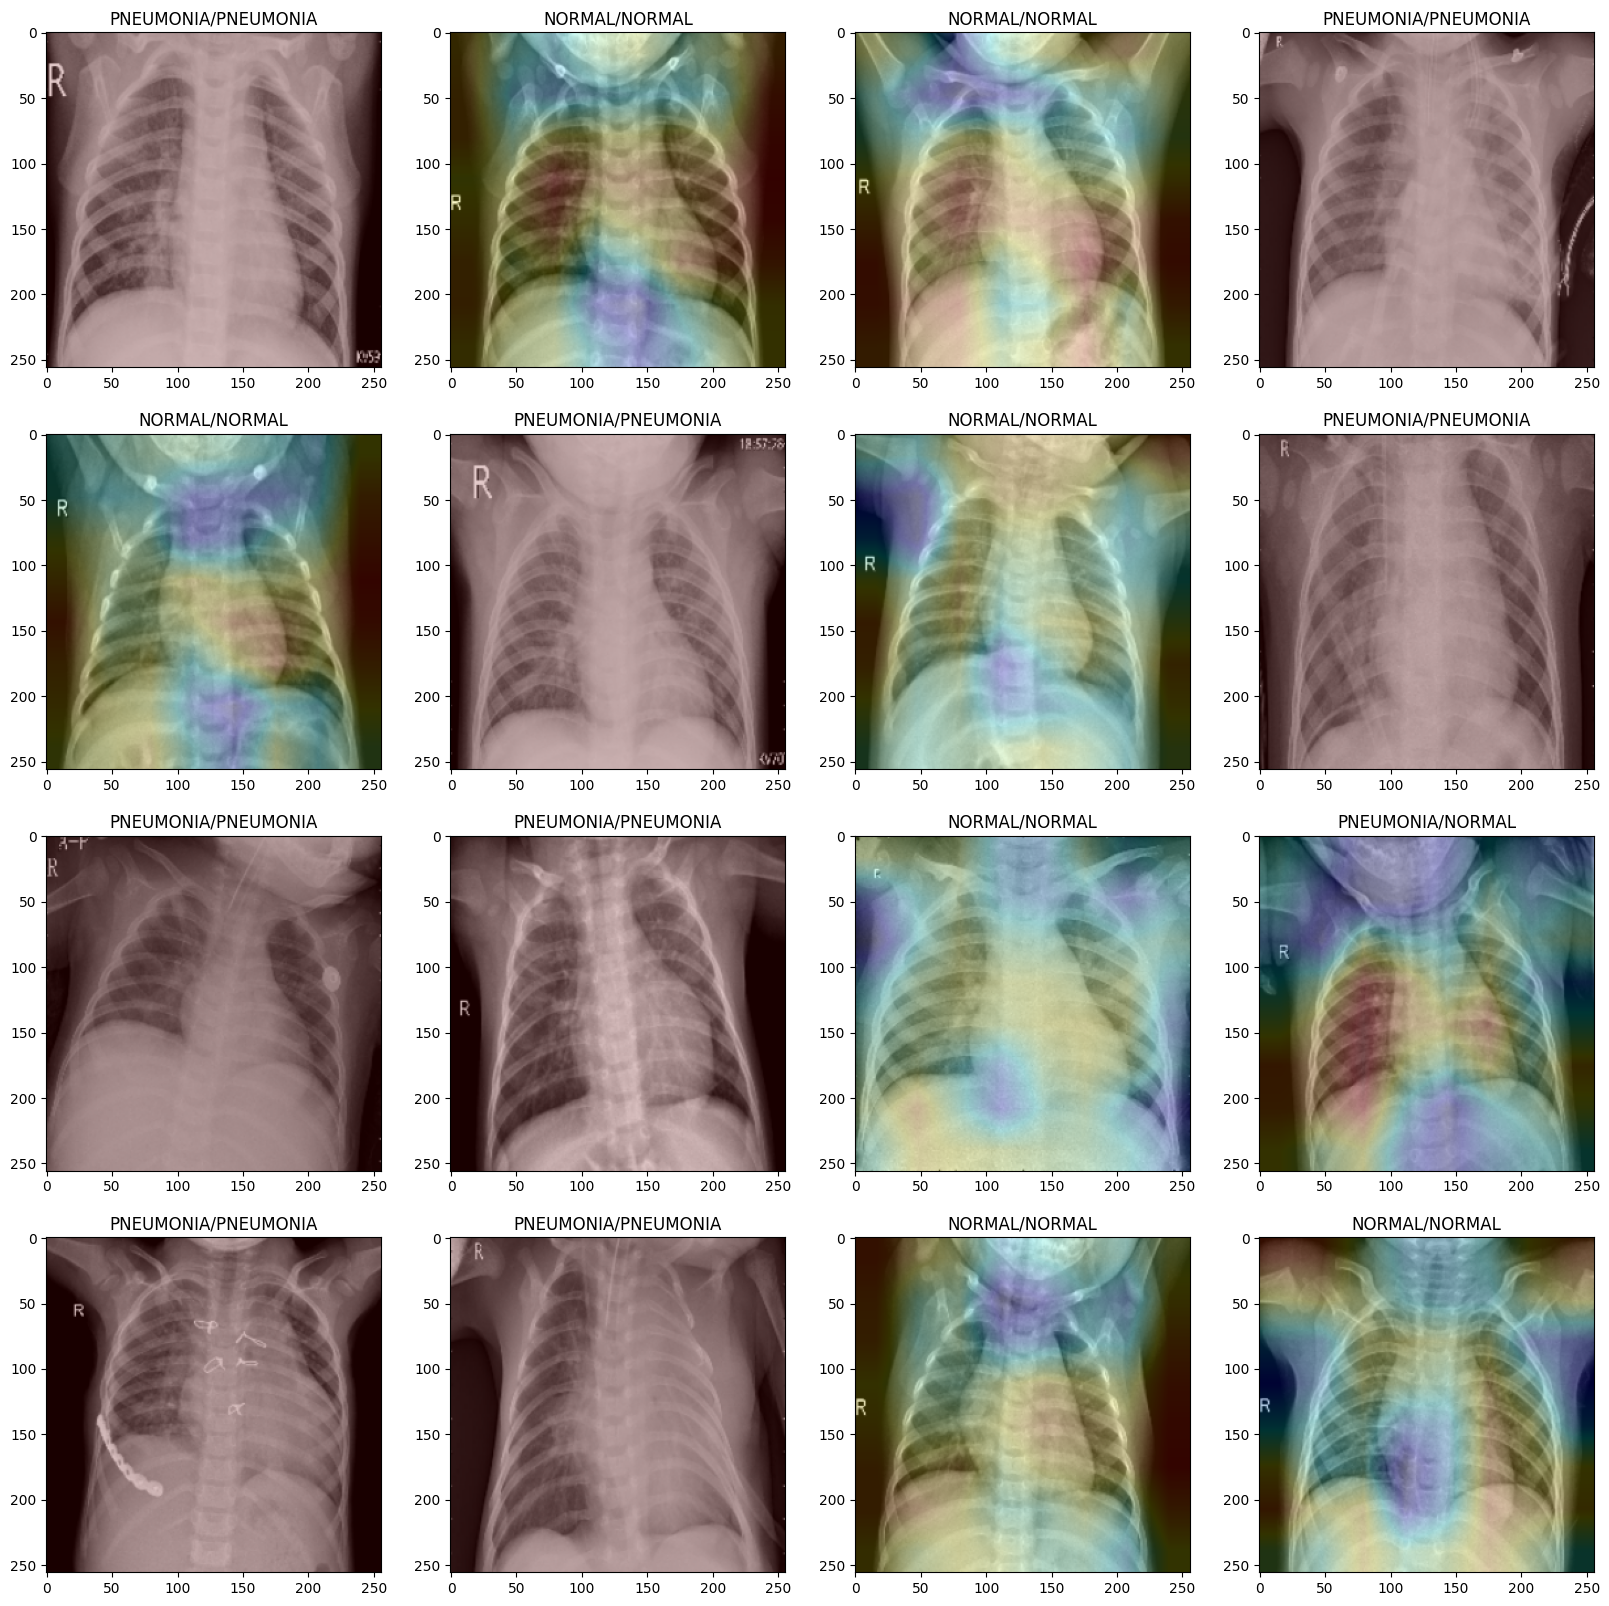

In [131]:
# Number of rows and columns in the grid of images
row, col = 4, 4

# Create a figure and subplots grid
fig, axes = plt.subplots(row, col, figsize=(20, 20))

# Iterate over a subset of the test dataset
for index, x in enumerate(test_ds.take(row * col)):
    
    # Unpack the input and label from the current iteration
    x_test, y_test = x  
     
    # Resize the input image to the specified size
    x_test = tf.image.resize(x_test, IMG_SIZE)
    
    # Perform prediction on the resized image
    y_pred = loaded_model.predict(tf.expand_dims(x_test, axis=0), verbose=0).argmax()
    
    # Generate GradCAM heatmap
    grad_heatmap = gradCam.gradCAM(x_test, name='block5_pool', index_class=y_test.numpy().argmax())
    
    # Display the GradCAM heatmap in the corresponding subplot
    axes[index // row, index % col].imshow(grad_heatmap)
    
    # Set the title for the subplot
    axes[index // row, index % col].set_title(f"{CLASS_NAMES[y_pred]}/{CLASS_NAMES[y_test.numpy().argmax()]}")
    
    # Break the loop if all subplots have been filled
    if index == (row * col) - 1:
        break
        
# Display the figure with subplots       
plt.show()
    

# Evaluate the model performance

In [135]:
def conf_matrix(y_test=None, y_pred=None, class_names=None):
    
    cm = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    a = ax.matshow(cm, cmap=plt.cm.Greens)  
    
    fig.colorbar(a)  
    
    ax.set(title="Confusion Matrix",
             xlabel="Predicted label",
             ylabel="Actual label",
             xticks=np.arange(len(class_names)), 
             yticks=np.arange(len(class_names)), 
             xticklabels=class_names,  
             yticklabels=class_names)
    
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    plt.xticks(rotation=60, fontsize=20)
    plt.yticks(fontsize=20)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}",
                  horizontalalignment="center", color="black" if cm[i, j] < (cm.max() + cm.min()) / 2 else "white",
                  fontsize=12)

In [148]:
y_pred = []
y_truth = []

for x, y in test:
    y_pred.extend(loaded_model.predict([x], verbose=0).round())
    y_truth.extend(y.numpy())
    
y_true = np.array(y_truth).argmax(axis=1)
y_prediction = np.array(y_pred).argmax(axis=1)

In [149]:
# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_prediction)
precision = precision_score(y_true, y_prediction, average='macro')
recall = recall_score(y_true, y_prediction, average='macro')
f1 = f1_score(y_true, y_prediction, average='macro')
confusion_mat = confusion_matrix(y_true, y_prediction)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_mat))

Accuracy: 0.9863880368098159
Precision: 0.981620535148646
Recall: 0.9827925236342643
F1-score: 0.9822046373484171

Confusion Matrix:
      0     1
0  1308    33
1    38  3837


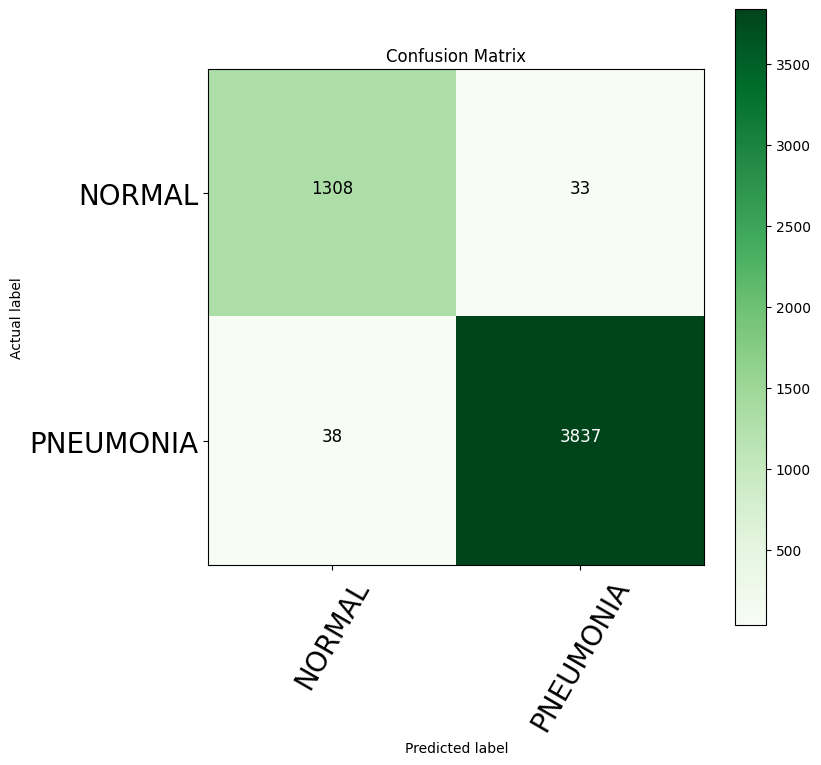

In [152]:
conf_matrix(y_test=y_true, y_pred=y_prediction, class_names=CLASS_NAMES)